This notebook contains testing code for recognising text from images.  

In [0]:
# Import all libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split

from pathlib import Path
from skimage import io, transform
from PIL import Image
import copy,os,sys
import random
import math
import pickle
import string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [0]:
# Make all models

# Create residual block
class unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(unit,self).__init__()
        
        self.BN1=nn.BatchNorm2d(in_channels)
        self.BN2=nn.BatchNorm2d(out_channels)
        self.conv1x1=nn.Conv2d(in_channels, out_channels, 1)
        self.conv3x3=nn.Conv2d(out_channels, out_channels, 3, padding=1)
        
    def forward(self,x):
        y=self.conv1x1(F.relu(self.BN1(x)))
        y=self.conv3x3(F.relu(self.BN2(y)))
        # y=self.conv1x1(F.relu(x))
        # y=self.conv3x3(F.relu(y))
        # x=torch.cat((x,y),dim=1)
        x=x+y
        return x
    
# Create encoder CNN
class Encoder_CNN(nn.Module):
    def __init__(self):
        super(Encoder_CNN,self).__init__()
        self.b0=nn.Conv2d(3,32,3,padding=1)

        self.conv01=nn.Conv2d(32,32,3,stride=2,padding=1)
        self.b1=nn.Sequential(unit(32,32),unit(32,32),unit(32,32))
        
        self.conv12=nn.Conv2d(32,64,3,stride=2,padding=1)
        self.b2=nn.Sequential(unit(64,64),unit(64,64),unit(64,64),unit(64,64))
                
        self.conv23=nn.Conv2d(64,128,3,stride=(2,1),padding=1)
        self.b3=nn.Sequential(unit(128,128),unit(128,128),unit(128,128),unit(128,128),unit(128,128),unit(128,128))
        
        self.conv34=nn.Conv2d(128,256,3,stride=(2,1),padding=1)
        self.b4=nn.Sequential(unit(256,256),unit(256,256),unit(256,256),unit(256,256),unit(256,256),unit(256,256))
        
        self.conv45=nn.Conv2d(256,512,3,stride=(2,1),padding=1)
        self.b5=nn.Sequential(unit(512,512),unit(512,512),unit(512,512))
        
    def forward(self,x):
        x=self.b0(x)
        x=self.b1(self.conv01(F.relu(x)))
        x=self.b2(self.conv12(F.relu(x)))
        x=self.b3(self.conv23(F.relu(x)))
        x=self.b4(self.conv34(F.relu(x)))
        x=self.b5(self.conv45(F.relu(x)))
        return x
        
# Create decoder LSTM
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        embed_size=round(vocab_size**0.25)

        self.lstm_cell=nn.LSTMCell(embed_size+512,512) 
        self.embeddings=nn.Embedding(vocab_size,embed_size)
        self.ench=nn.Linear(512,256)   # V in paper
        self.dech=nn.Linear(512,256)   # W in paper
        self.w=nn.Linear(256,1,bias=False)
        self.lin1=nn.Linear(512,256)
        self.linout=nn.Linear(256,vocab_size)
            
            
    # enc_h is all encoder hidden states (N,seq_len,512)
    # h is last hidden state of encoder for all layers (num_layers*directions,N,256)
    # c is last cell state of encoder for all layers (num_layers*directions,N,256)
    def forward(self,enc_h,h,c):
        h=h[2:].transpose(0,1).contiguous()   # take last layer only
        h=h.view(h.size(0),-1)    # (N,512)
        c=c[2:].transpose(0,1).contiguous()
        c=c.view(c.size(0),-1)    # (N,512)
        
        inp=torch.ones((1),dtype=torch.long,device=device)*label2idx['<sos>']  # input at t=1 is <sos> 
        out_list, alpha_list=[], []

        # for t in range(3):
        # Run till eos is reached or 20 characters are predicted
        while inp[0]!=label2idx['<eos>']:
            if len(out_list)==20:
                break
            inp=self.embeddings(inp)
            g,alpha=self.step(enc_h,h)
            h,c=self.lstm_cell(torch.cat((inp,g),dim=1),(h,c))
            out=self.linout(F.relu(self.lin1(h)))
            inp=torch.argmax(out).unsqueeze(0)
            out_list.append(inp.squeeze())       # adding time dimension
            alpha_list.append(alpha.unsqueeze(1))   # adding time dimension
            
        # out_list=torch.cat(out_list,dim=1)   
        alpha_list=torch.cat(alpha_list,dim=1)   
        # out_list=F.log_softmax(out_list,dim=2)
        return out_list,alpha_list
    
    # generates glimpse vector between decoder's prev hidden state and all encoder hidden states for a single t
    def step(self,enc_h,h):
        h=h.unsqueeze(1)
        e=self.w(torch.tanh(self.dech(h)+self.ench(enc_h)))
        e=e.squeeze(-1)
        alpha=torch.softmax(e,dim=1)
        g=torch.einsum('bi,bij->bj',alpha,enc_h)
        return g, alpha
        
# Combines both the CNN encoder and LSTM decoder to produce final output 
class Recognition(nn.Module):
    def __init__(self):
        super(Recognition,self).__init__()
        
        self.enc_cnn=Encoder_CNN()
        self.enc_rnn=nn.LSTM(512,256,num_layers=2,batch_first=True,bidirectional=True)
#         self.lin1=nn.Linear(512,256)
        self.decoder1=Decoder()
        self.decoder2=Decoder()    
        
    def forward(self,x):
        x=self.enc_cnn(x)
        x=x.permute((0,3,1,2)).squeeze(-1)   # reshapes to (batch_size,seq_length,feature_length)
        out,(h,c) =self.enc_rnn(x)
        fout_list, falpha_list=self.decoder1(out,h,c)      # forward decoder
        return fout_list, falpha_list

In [0]:
# Get all letters, digits and punctutation from the string class
labels=string.punctuation+string.ascii_letters+string.digits
labels=list(labels)+['<sos>','<eos>']

label2idx={val:i for i,val in enumerate(labels)}
idx2label={i:val for i,val in enumerate(labels)}
vocab_size=len(label2idx)


def normalize(x,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):
    mean=torch.tensor(mean).to(device)
    std=torch.tensor(std).to(device)
    return (x-mean)/std
    
def denormalize(x,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):
    mean=torch.tensor(mean).to(device)
    std=torch.tensor(std).to(device)
    return x*std+mean
    
# changes dim of x from (w,h,3)->(1,3,w,h) to easily pass through model
def img2passable(x):
    x=x.permute((2,0,1))
    x=x.unsqueeze(0)
    return x

# inverse of img_to_passable
# converts (1,3,w,h) to (w,h,3)
def passable2img(x):
    x=x.squeeze(0)
    x=x.permute((1,2,0))
    return x

# x is list of labels and output is list of indices
def labels2idx(x):
    return [label2idx[i.item()] for i in x]

def idx2labels(x):
    return [idx2label[i.item()] for i in x]

# x is list of indices
# returns string of text
def get_label(x):
    return ''.join(idx2labels(x)[:-1])  # Removes <eos>

In [0]:
# test_img should be of (32,100,3)
# Get output prediction from the model and also the attention weights 
def get_output(test_img): 
    test_img=img2passable(normalize(test_img)).to(device)
    with torch.no_grad():
        return model(test_img)

# decodes the prediction given the index labels
def decode(prediction):    
    for pred in prediction:
        if idx2label[pred.item()]!='<eos>':
            print(idx2label[pred.item()],end='')

In [0]:
# load the image
def load_image(name):
    loader = transforms.Compose([
        transforms.Resize((32,100)),   # scale imported image
        transforms.ToTensor()])        # transform PIL image to torch tensor

    image = Image.open(name)
    image = loader(image)
    image=image[:3]         # take only the first three channels
    return image.float().unsqueeze(0).to(device)

# load the model 
def load_model(model_path):
    model = Recognition().to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

Change the below paths for image and model

In [0]:
img_path='/example.png'
model_path ='/text_recognition.pth'         

test_img=load_image(img_path)
model=load_model(model_path)

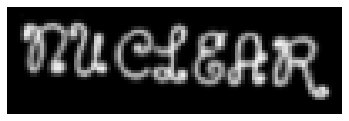

In [9]:
# Show the image
fig,ax=plt.subplots()
ax.imshow(passable2img(test_img).cpu())
ax.set_axis_off()
plt.show()

In [11]:
# Get decoded output
output, alphas = get_output(passable2img(test_img))
decode(output)

NUCLEAR

N


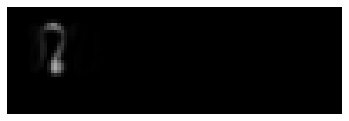

U


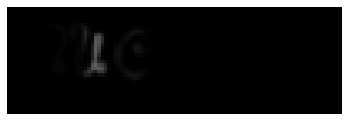

C


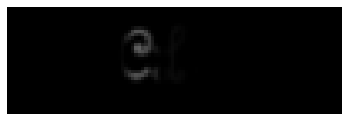

L


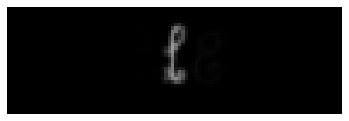

E


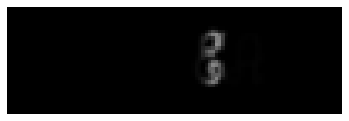

A


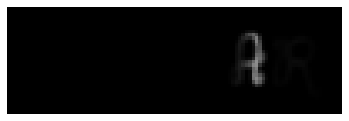

R


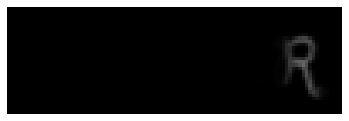

In [15]:
# Get output with attention at every time step
I=passable2img(test_img.detach().cpu()).numpy()
for i in range(alphas.size(1)-1):    # last time is for <eos> token
    a=F.interpolate(alphas,scale_factor=4,mode='linear')[0,i,:]
    a=a.unsqueeze(0).unsqueeze(2)
    a=a.expand(32,-1,3)
    print(idx2label[output[i].item()])
    plt.imshow(a.detach().cpu().numpy()*I)
    plt.axis('off')
    plt.show()